# Week 4: Data Preprocessing & Feature Engineering

This notebook covers:
1. Data cleaning and preprocessing
2. Feature encoding and scaling
3. Feature engineering and selection
4. Data splitting for ML
5. Preparation for model training

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import joblib

# Set up paths
DATA_PROCESSED = Path('../data/processed')
MODELS = Path('../models')
MODELS.mkdir(exist_ok=True)

print("✅ Libraries imported and paths set up")

✅ Libraries imported and paths set up


In [2]:
# Load the ingredient database
print("📊 Loading ingredient database...")
ingredient_db = pd.read_csv(DATA_PROCESSED / 'ingredient_toxicity_db.csv')

print(f"✅ Loaded {len(ingredient_db)} ingredients")
print(f"Columns: {list(ingredient_db.columns)}")
print(f"Shape: {ingredient_db.shape}")

# Display first few rows
ingredient_db.head()

📊 Loading ingredient database...
✅ Loaded 40 ingredients
Columns: ['ingredient_name', 'toxicity_score', 'category', 'health_impact', 'allergen_risk', 'is_toxic', 'risk_level']
Shape: (40, 7)


,ingredient_name,toxicity_score,category,health_impact,allergen_risk,is_toxic,risk_level
0,trans_fat,95,fat,very_high,none,1,High Risk
1,high_fructose_corn_syrup,90,sweetener,very_high,none,1,High Risk
2,sodium_nitrite,90,preservative,very_high,none,1,High Risk
3,bha,85,preservative,high,none,1,High Risk
4,bht,85,preservative,high,none,1,High Risk


In [3]:
# Data preprocessing pipeline
print("🔧 PREPROCESSING PIPELINE")
print("=" * 40)

# Create a copy for preprocessing
df_processed = ingredient_db.copy()

# 1. Handle missing values (if any)
print("\n1️⃣ Checking for missing values...")
missing_values = df_processed.isnull().sum()
print(f"Missing values: {missing_values.sum()}")
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("✅ No missing values found")

# 2. Remove duplicates (if any)
print("\n2️⃣ Checking for duplicates...")
duplicates = df_processed.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
if duplicates > 0:
    df_processed = df_processed.drop_duplicates()
    print(f"✅ Removed {duplicates} duplicate rows")
else:
    print("✅ No duplicates found")

# 3. Data type optimization
print("\n3️⃣ Optimizing data types...")
print("Before optimization:")
print(df_processed.dtypes)

# Convert categorical columns to category type
categorical_cols = ['category', 'health_impact', 'risk_level', 'allergen_risk']
for col in categorical_cols:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype('category')

print("\nAfter optimization:")
print(df_processed.dtypes)
print("✅ Data types optimized")

🔧 PREPROCESSING PIPELINE

1️⃣ Checking for missing values...
Missing values: 8
risk_level    8
dtype: int64

2️⃣ Checking for duplicates...
Duplicate rows: 0
✅ No duplicates found

3️⃣ Optimizing data types...
Before optimization:
ingredient_name    object
toxicity_score      int64
category           object
health_impact      object
allergen_risk      object
is_toxic            int64
risk_level         object
dtype: object

After optimization:
ingredient_name      object
toxicity_score        int64
category           category
health_impact      category
allergen_risk      category
is_toxic              int64
risk_level         category
dtype: object
✅ Data types optimized


In [4]:
# Feature encoding
print("🏷️ FEATURE ENCODING")
print("=" * 30)

# Separate features and target
target_col = 'is_toxic'
feature_cols = [col for col in df_processed.columns if col not in [target_col, 'ingredient_name']]

print(f"Target variable: {target_col}")
print(f"Feature columns: {feature_cols}")

# Initialize encoders
label_encoders = {}
encoded_features = df_processed[feature_cols].copy()

# Encode categorical variables
categorical_features = encoded_features.select_dtypes(include=['category', 'object']).columns
print(f"\nCategorical features to encode: {list(categorical_features)}")

for col in categorical_features:
    le = LabelEncoder()
    encoded_features[f'{col}_encoded'] = le.fit_transform(encoded_features[col])
    label_encoders[col] = le
    print(f"✅ Encoded {col}: {len(le.classes_)} unique values")

# Remove original categorical columns
encoded_features = encoded_features.drop(columns=categorical_features)

print(f"\nFinal feature matrix shape: {encoded_features.shape}")
print(f"Features: {list(encoded_features.columns)}")

🏷️ FEATURE ENCODING
Target variable: is_toxic
Feature columns: ['toxicity_score', 'category', 'health_impact', 'allergen_risk', 'risk_level']

Categorical features to encode: ['category', 'health_impact', 'allergen_risk', 'risk_level']
✅ Encoded category: 17 unique values
✅ Encoded health_impact: 6 unique values
✅ Encoded allergen_risk: 4 unique values
✅ Encoded risk_level: 5 unique values

Final feature matrix shape: (40, 5)
Features: ['toxicity_score', 'category_encoded', 'health_impact_encoded', 'allergen_risk_encoded', 'risk_level_encoded']


In [6]:
# Feature engineering
print("⚙️ FEATURE ENGINEERING")
print("=" * 35)

# Create additional features
engineered_features = encoded_features.copy()

# 1. Toxicity level categories (handle NaN values)
toxicity_bins = pd.cut(
    engineered_features['toxicity_score'], 
    bins=[0, 20, 40, 70, 100], 
    labels=[0, 1, 2, 3]  # Safe, Low, Medium, High
)
engineered_features['toxicity_level'] = toxicity_bins.fillna(1).astype(int)  # Fill NaN with 1 (Low)

# 2. High toxicity flag
engineered_features['high_toxicity_flag'] = (engineered_features['toxicity_score'] > 70).astype(int)

# 3. Toxicity score squared (for non-linear relationships)
engineered_features['toxicity_score_squared'] = engineered_features['toxicity_score'] ** 2

# 4. Toxicity score normalized (0-1 scale)
engineered_features['toxicity_score_normalized'] = (
    engineered_features['toxicity_score'] / 100
)

print(f"✅ Created {len(engineered_features.columns) - len(encoded_features.columns)} new features")
print(f"New features: {[col for col in engineered_features.columns if col not in encoded_features.columns]}")
print(f"Total features: {engineered_features.shape[1]}")

# Display feature statistics
print("\n📊 Feature Statistics:")
engineered_features.describe()


⚙️ FEATURE ENGINEERING
✅ Created 4 new features
New features: ['toxicity_level', 'high_toxicity_flag', 'toxicity_score_squared', 'toxicity_score_normalized']
Total features: 9

📊 Feature Statistics:


,toxicity_score,category_encoded,health_impact_encoded,allergen_risk_encoded,risk_level_encoded,toxicity_level,high_toxicity_flag,toxicity_score_squared,toxicity_score_normalized
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000
mean,39.375000,9.700000,2.475000,1.825000,1.925000,1.47500,0.225000,2511.875000,0.393750
std,31.402831,4.967587,1.986977,0.594311,1.456858,1.03744,0.422902,2856.341278,0.314028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,16.250000,5.750000,0.750000,2.000000,1.000000,1.00000,0.000000,306.250000,0.162500
50%,37.500000,11.000000,2.500000,2.000000,2.000000,1.00000,0.000000,1412.500000,0.375000
75%,66.250000,14.000000,5.000000,2.000000,3.000000,2.00000,0.000000,4393.750000,0.662500
max,95.000000,16.000000,5.000000,3.000000,4.000000,3.00000,1.000000,9025.000000,0.950000


In [7]:
# Feature scaling
print("📏 FEATURE SCALING")
print("=" * 25)

# Prepare features and target
X = engineered_features
y = df_processed[target_col]

print(f"Feature matrix X: {X.shape}")
print(f"Target vector y: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data Split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\n✅ Features scaled using StandardScaler")
print(f"Scaled training features mean: {X_train_scaled.mean().mean():.3f}")
print(f"Scaled training features std: {X_train_scaled.std().mean():.3f}")

📏 FEATURE SCALING
Feature matrix X: (40, 9)
Target vector y: (40,)
Target distribution: {0: 27, 1: 13}

📊 Data Split:
Training set: (32, 9)
Test set: (8, 9)
Training target distribution: {0: 22, 1: 10}
Test target distribution: {0: 5, 1: 3}

✅ Features scaled using StandardScaler
Scaled training features mean: 0.000
Scaled training features std: 1.016


In [8]:
# Feature selection
print("🎯 FEATURE SELECTION")
print("=" * 30)

# 1. Correlation-based feature selection
print("\n1️⃣ Correlation Analysis:")
correlation_matrix = X_train_scaled.corr()

# Find highly correlated features
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("High correlation pairs (>0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} - {feat2}: {corr:.3f}")
else:
    print("✅ No highly correlated features found")

# 2. Statistical feature selection
print("\n2️⃣ Statistical Feature Selection:")
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# Get feature scores
feature_scores = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('score', ascending=False)

print("Feature importance scores:")
print(feature_scores)

# Select top features
top_k = min(8, len(X_train_scaled.columns))  # Select top 8 features or all if less
top_features = feature_scores.head(top_k)['feature'].tolist()

print(f"\n🎯 Selected top {len(top_features)} features:")
for i, feat in enumerate(top_features, 1):
    score = feature_scores[feature_scores['feature'] == feat]['score'].iloc[0]
    print(f"  {i}. {feat}: {score:.2f}")

🎯 FEATURE SELECTION

1️⃣ Correlation Analysis:
High correlation pairs (>0.8):
  toxicity_score - risk_level_encoded: -0.900
  toxicity_score - toxicity_level: 0.874
  toxicity_score - high_toxicity_flag: 0.812
  toxicity_score - toxicity_score_squared: 0.962
  toxicity_score - toxicity_score_normalized: 1.000
  risk_level_encoded - toxicity_score_squared: -0.831
  risk_level_encoded - toxicity_score_normalized: -0.900
  toxicity_level - high_toxicity_flag: 0.816
  toxicity_level - toxicity_score_squared: 0.903
  toxicity_level - toxicity_score_normalized: 0.874
  high_toxicity_flag - toxicity_score_squared: 0.907
  high_toxicity_flag - toxicity_score_normalized: 0.812
  toxicity_score_squared - toxicity_score_normalized: 0.962

2️⃣ Statistical Feature Selection:
Feature importance scores:
                     feature       score       p_value
7     toxicity_score_squared  204.838425  6.063932e-15
8  toxicity_score_normalized   96.758833  6.705531e-11
0             toxicity_score   96.7

📉 DIMENSIONALITY REDUCTION (PCA)
Original features: 9
PCA components: 4
Explained variance ratio: [0.60387317 0.16684263 0.1039127  0.07883296]
Total explained variance: 0.953


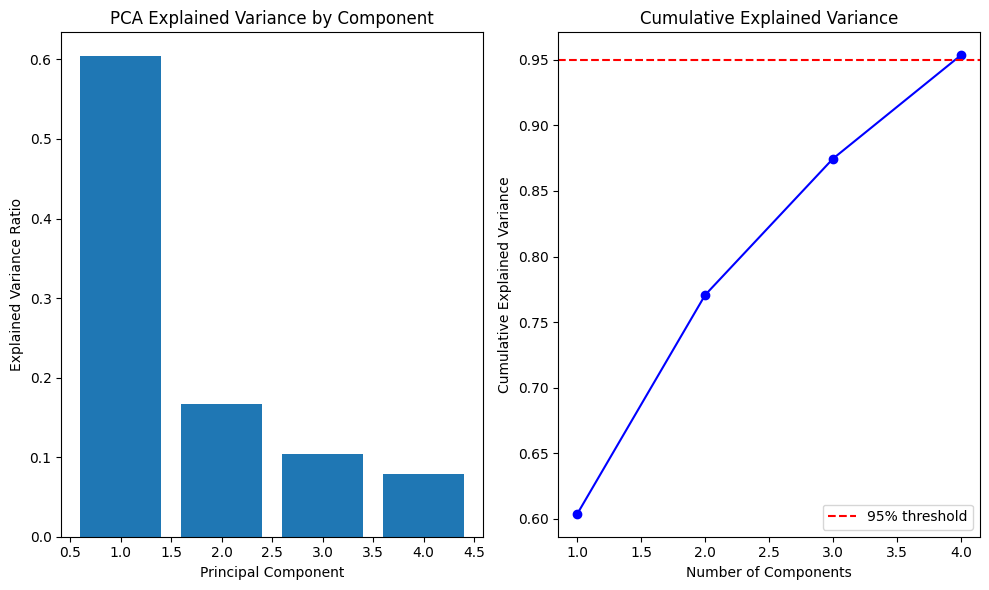

✅ PCA analysis completed and saved


In [9]:
# Dimensionality reduction (PCA)
print("📉 DIMENSIONALITY REDUCTION (PCA)")
print("=" * 45)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"PCA components: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('PCA Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.legend()

plt.tight_layout()
plt.savefig('../reports/figures/pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ PCA analysis completed and saved")

In [10]:
# Save preprocessed data and models
print("💾 SAVING PREPROCESSED DATA")
print("=" * 40)

# Create final datasets
datasets = {
    'original': {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    },
    'scaled': {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    },
    'selected_features': {
        'X_train': X_train_scaled[top_features],
        'X_test': X_test_scaled[top_features],
        'y_train': y_train,
        'y_test': y_test
    },
    'pca': {
        'X_train': pd.DataFrame(X_train_pca, index=X_train.index),
        'X_test': pd.DataFrame(X_test_pca, index=X_test.index),
        'y_train': y_train,
        'y_test': y_test
    }
}

# Save datasets
for dataset_name, data in datasets.items():
    dataset_dir = DATA_PROCESSED / dataset_name
    dataset_dir.mkdir(exist_ok=True)
    
    for data_name, df in data.items():
        filepath = dataset_dir / f'{data_name}.csv'
        df.to_csv(filepath, index=True)
    
    print(f"✅ Saved {dataset_name} dataset: {data['X_train'].shape}")

# Save preprocessing objects
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'pca': pca,
    'feature_selector': selector,
    'top_features': top_features
}

for obj_name, obj in preprocessing_objects.items():
    filepath = MODELS / f'{obj_name}.pkl'
    joblib.dump(obj, filepath)
    print(f"✅ Saved {obj_name}")

print(f"\n📁 All preprocessed data saved to: {DATA_PROCESSED}")
print(f"📁 All preprocessing objects saved to: {MODELS}")

💾 SAVING PREPROCESSED DATA
✅ Saved original dataset: (32, 9)
✅ Saved scaled dataset: (32, 9)
✅ Saved selected_features dataset: (32, 8)
✅ Saved pca dataset: (32, 4)
✅ Saved scaler
✅ Saved label_encoders
✅ Saved pca
✅ Saved feature_selector
✅ Saved top_features

📁 All preprocessed data saved to: ../data/processed
📁 All preprocessing objects saved to: ../models


In [11]:
# Preprocessing summary
print("📋 PREPROCESSING SUMMARY")
print("=" * 35)

summary = {
    'Original Data': {
        'Samples': len(ingredient_db),
        'Features': len(ingredient_db.columns) - 2,  # Exclude target and ingredient name
        'Missing Values': ingredient_db.isnull().sum().sum(),
        'Duplicates': ingredient_db.duplicated().sum()
    },
    'Feature Engineering': {
        'Original Features': len(encoded_features.columns),
        'Engineered Features': len(engineered_features.columns),
        'New Features Created': len(engineered_features.columns) - len(encoded_features.columns)
    },
    'Data Splitting': {
        'Training Samples': len(X_train),
        'Test Samples': len(X_test),
        'Training Positive Class': y_train.sum(),
        'Test Positive Class': y_test.sum()
    },
    'Feature Selection': {
        'Total Features': len(X_train_scaled.columns),
        'Selected Features': len(top_features),
        'PCA Components': X_train_pca.shape[1],
        'PCA Variance Explained': f"{pca.explained_variance_ratio_.sum():.1%}"
    }
}

for section, metrics in summary.items():
    print(f"\n📊 {section}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# Save summary
import json
with open(DATA_PROCESSED / 'preprocessing_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print("\n💾 Preprocessing summary saved")
print("\n🎉 Week 4 Data Preprocessing Complete!")
print("\n📋 Next Steps (Week 5):")
print("  1. Baseline model development")
print("  2. Decision Tree implementation")
print("  3. Random Forest training")
print("  4. Model evaluation and comparison")

📋 PREPROCESSING SUMMARY

📊 Original Data:
  Samples: 40
  Features: 5
  Missing Values: 8
  Duplicates: 0

📊 Feature Engineering:
  Original Features: 5
  Engineered Features: 9
  New Features Created: 4

📊 Data Splitting:
  Training Samples: 32
  Test Samples: 8
  Training Positive Class: 10
  Test Positive Class: 3

📊 Feature Selection:
  Total Features: 9
  Selected Features: 8
  PCA Components: 4
  PCA Variance Explained: 95.3%

💾 Preprocessing summary saved

🎉 Week 4 Data Preprocessing Complete!

📋 Next Steps (Week 5):
  1. Baseline model development
  2. Decision Tree implementation
  3. Random Forest training
  4. Model evaluation and comparison
